<a href="https://colab.research.google.com/github/taylor33189-beep/Taylor_Hoskins_Repository/blob/main/Analysis_of_a_variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Summary of Folate Levels by Treatment Group ---
                    count    mean    std
treatment_label                         
N2O Continuous          8  316.62  58.72
N2O Operation Only      9  256.44  37.12
O2 Control              5  278.00  33.76

An error occurred during plotting: 'NoneType' object has no attribute 'dpi'
--- 2. Overall Hypothesis Test (ANOVA) ---

I. Hypotheses:
   - Null Hypothesis (H0): The true mean red cell folate levels are
     EQUAL across ALL three treatment groups.
   - Alternative Hypothesis (Ha): At least one pair of treatment groups
     has a DIFFERENT true mean red cell folate level.

II. Results from the ANOVA Test:
                       sum_sq    df         F    PR(>F)
treatment_label  15515.766414   2.0  3.711336  0.043589
Residual         39716.097222  19.0       NaN       NaN

Interpretation of ANOVA Results (at alpha = 0.05):
The test result (F-statistic) is 3.7113, with a low probability
of observing this if there's no difference (p-val

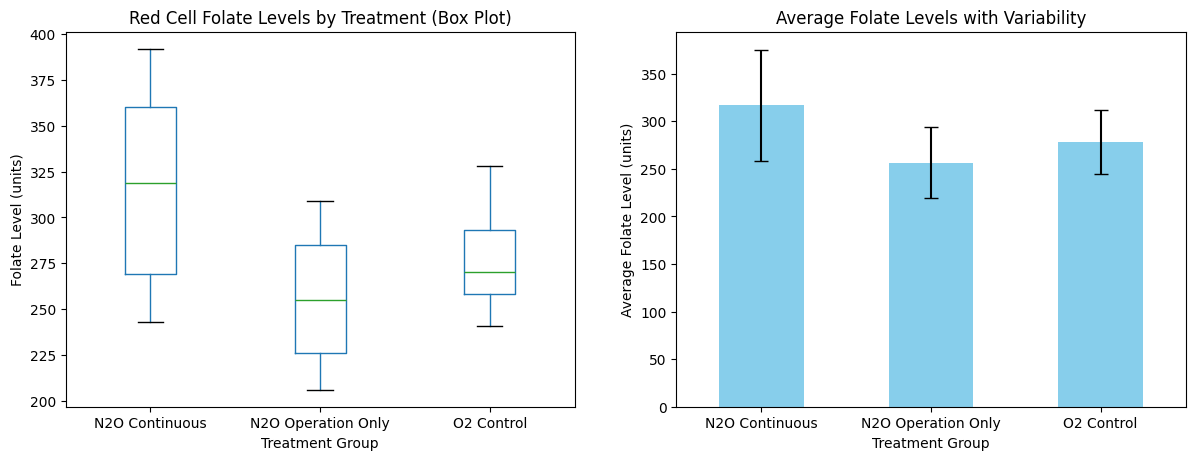

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- Getting the Data Ready ---

# Load the data from the CSV file named 'amess (1).csv'.
# The first row (row 0) contains the names for the columns (the header).
try:
    df = pd.read_csv('amess (1).csv', header=0)

    # The 'treatmnt' column indicates the treatment group.
    # This column is treated as a category (factor).
    df['treatmnt'] = df['treatmnt'].astype('category')

    # Give informative labels to the factor levels.
    # 1: 50% N2O / 50% O2 continuous
    # 2: 50% N2O / 50% O2 operation only
    # 3: No N2O / 35-50% O2 continuous (Control)
    treatment_labels = {
        1: 'N2O Continuous',
        2: 'N2O Operation Only',
        3: 'O2 Control'
    }
    # Create a new column with these labels.
    df['treatment_label'] = df['treatmnt'].map(treatment_labels)

    # Display basic information about the 'folate' levels for each
    # treatment group: count, mean, and standard deviation.
    print("--- Summary of Folate Levels by Treatment Group ---")
    print(df.groupby('treatment_label', observed=False)['folate'].agg(
        ['count', 'mean', 'std']).round(2))
    print("\n" + "="*50)


    # --- 1. Data Visualization ---

    def visualize_data(dataframe):
        """
        Creates charts (Box Plot and Bar Plot) to visualize the data.
        Handles potential plotting issues like empty data.
        """
        if dataframe.empty:
            print("Cannot visualize data: The dataframe is empty.")
            return

        try:
            # Set up two charts side-by-side.
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            # Box Plot: Useful for comparing distributions and spotting outliers.
            # Check if there is enough data to plot.
            if not dataframe.groupby('treatment_label', observed=False)['folate'].count().empty:
                dataframe.boxplot(column='folate', by='treatment_label',
                                  ax=axes[0], grid=False)
                # Title for the first chart
                axes[0].set_title(
                    'Red Cell Folate Levels by Treatment (Box Plot)')
                axes[0].set_xlabel('Treatment Group') # Label for bottom axis
                axes[0].set_ylabel('Folate Level (units)') # Label for side axis

                # Remove the automatic suptitle if it exists (often created by
                # `by` in boxplot). Check if a suptitle exists before removing.
                if fig._suptitle:
                    fig._suptitle.remove()
            else:
                axes[0].set_title('Box Plot: No data to display')
                axes[0].set_xlabel('Treatment Group')
                axes[0].set_ylabel('Folate Level (units)')


            # Bar Plot with Standard Deviation: Shows average folate level
            # for each group with variability indicated by error bars.
            # Calculate the average folate for each group.
            mean_folate = dataframe.groupby('treatment_label', observed=False)['folate'].mean()
            # Calculate how much the data varies (standard deviation).
            std_folate = dataframe.groupby('treatment_label', observed=False)['folate'].std()

            # Check if there is data to plot.
            if not mean_folate.empty:
                # Create bar chart with variability lines.
                mean_folate.plot(kind='bar', yerr=std_folate, ax=axes[1],
                                 capsize=5, color='skyblue')
                # Title for the second chart.
                axes[1].set_title('Average Folate Levels with Variability')
                axes[1].set_xlabel('Treatment Group') # Label for bottom axis
                axes[1].set_ylabel('Average Folate Level (units)') # Label for side axis
                plt.xticks(rotation=0) # Keep group names horizontal
            else:
                axes[1].set_title('Bar Plot: No data to display')
                axes[1].set_xlabel('Treatment Group')
                axes[1].set_ylabel('Average Folate Level (units)')


            # Get the current figure before adjusting layout and showing.
            plt.gcf().tight_layout() # Adjust spacing between charts.
            plt.show() # Display the charts.

        except Exception as e:
            print(f"An error occurred during plotting: {e}")


    # Display the charts.
    visualize_data(df)


    # --- 2. Overall Hypothesis Test (ANOVA) ---

    print("--- 2. Overall Hypothesis Test (ANOVA) ---")

    # I. Hypotheses being tested:
    print("\nI. Hypotheses:")
    print("   - Null Hypothesis (H0): The true mean red cell folate levels are")
    print("     EQUAL across ALL three treatment groups.")
    print("   - Alternative Hypothesis (Ha): At least one pair of treatment groups")
    print("     has a DIFFERENT true mean red cell folate level.")

    # II. Perform One-Way ANOVA.
    # The OLS model is specified as: Dependent_Variable ~ Independent_Factor
    model = ols('folate ~ treatment_label', data=df).fit() # Set up the test.
    anova_table = sm.stats.anova_lm(model, typ=2) # Run the test and get results.

    print("\nII. Results from the ANOVA Test:")
    print(anova_table)

    # Interpretation of results:
    # The 'P>F' value (p-value) indicates the probability of observing the data
    # if there were no real difference between the groups.
    # This p-value is compared to the significance level (alpha), typically 0.05.
    # If the p-value is less than 0.05, the results are considered
    # "statistically significant," suggesting a real difference.

    # Get the F-statistic value from the results.
    f_stat = anova_table.loc['treatment_label', 'F']
    # Get the p-value from the results.
    p_value = anova_table.loc['treatment_label', 'PR(>F)']

    alpha = 0.05 # Significance cutoff.

    print(f"\nInterpretation of ANOVA Results (at alpha = {alpha}):")
    if p_value < alpha:
        print(f"The test result (F-statistic) is {f_stat:.4f}, with a low probability")
        print("of observing this if there's no difference (p-value =")
        print(f"{p_value:.4e}).")
        print("Since the p-value is less than the cutoff (0.05), **REJECT the**")
        print("**null hypothesis that all groups have the same average folate level**.")
        print("Conclusion: There is a statistically significant difference in average")
        print("red cell folate levels somewhere among the three treatment groups.")
    else:
        print(f"The test result (F-statistic) is {f_stat:.4f}, with a probability")
        print(f"of observing this if there's no difference of {p_value:.4f}.")
        print("Since the p-value is greater than the cutoff (0.05), **FAIL TO**")
        print("**REJECT the null hypothesis**.")
        print("Conclusion: There is no statistically significant difference in average")
        print("red cell folate levels among the three treatment groups based on")
        print("this test.")


    # --- 3. Pairwise Group Differences (Post-Hoc Test) ---

    # This step is performed only if the main ANOVA test indicates a
    # difference exists (if H0 was rejected).
    if p_value < alpha:
        print("\n" + "="*50)
        print("--- 3. Finding Specific Differences (Bonferroni Post-Hoc Test) ---")
        print("Since the main test showed a difference, each pair of groups is")
        print("now compared to identify specific differences.")

        # The Bonferroni correction is applied to account for multiple comparisons,
        # adjusting the significance cutoff (alpha) to reduce the chance of false
        # positives.

        # Get all unique treatment group names.
        treatments = df['treatment_label'].unique()
        # Identify all possible pairs of groups to compare.
        pairwise_combinations = []
        for i in range(len(treatments)):
            for j in range(i + 1, len(treatments)):
                pairwise_combinations.append((treatments[i], treatments[j]))

        # Calculate the new, stricter cutoff for significance for each comparison.
        alpha_bonf = alpha / len(pairwise_combinations)
        print(f"\nNumber of pairs to compare = {len(pairwise_combinations)}")
        print(f"New, stricter significance cutoff (Bonferroni-adjusted alpha) =")
        print(f"{alpha_bonf:.4f}")

        bonf_results = []

        # Compare each pair of groups.
        for t1, t2 in pairwise_combinations:
            # Get folate levels for the first group.
            group1 = df[df['treatment_label'] == t1]['folate']
            # Get folate levels for the second group.
            group2 = df[df['treatment_label'] == t2]['folate']

            # Perform a two-sample t-test for the two groups.
            # This provides a p-value for this specific comparison.
            # Assuming unequal variance is a safer approach.
            t_stat, unadjusted_p = stats.ttest_ind(group1, group2,
                                                   equal_var=False)

            # Apply the Bonferroni correction: multiply the unadjusted p-value
            # by the number of pairs being compared. Ensure p-value <= 1.
            adjusted_p = min(unadjusted_p * len(pairwise_combinations), 1.0)

            # Check for significance against the original alpha (0.05).
            # Note: The ADJUSTED p-value is compared to the ORIGINAL alpha (0.05).
            is_significant = adjusted_p < alpha

            # Store the results for this pair.
            bonf_results.append({
                'Comparison': f"{t1} vs {t2}",
                'Unadjusted P': f"{unadjusted_p:.4e}", # P-value before adjustment
                'Bonferroni P': f"{adjusted_p:.4e}", # P-value after adjustment
                'Significant': is_significant # Indicates statistical significance
            })

        print("\nResults of Comparing Each Pair (Bonferroni Corrected):")
        # Print the results for each pair.
        for result in bonf_results:
            sig_marker = (
                "(* This difference IS significant *)" if result['Significant']
                else "(This difference is NOT significant)")
            print(f"  Comparing '{result['Comparison']}': The adjusted p-value is")
            print(f"{result['Bonferroni P']} {sig_marker}")

        # Final Conclusion from the Bonferroni Test.
        significant_pairs = [r['Comparison'] for r in bonf_results
                             if r['Significant']]

        if significant_pairs:
            print("\nFinal Conclusion from Bonferroni Test:")
            print("Based on the Bonferroni test, the following pairs of groups")
            print("have statistically significant differences in average folate levels:")
            for pair in significant_pairs:
                print(f"- {pair}")
        else:
            print("\nFinal Conclusion from Bonferroni Test: Based on this test,")
            print("no statistically significant differences were found between any")
            print("specific pair of treatment groups after accounting for multiple")
            print("comparisons.")

except FileNotFoundError:
    print("Error: The file 'amess (1).csv' was not found. Please ensure the")
    print("file is in the correct directory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")